In [19]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, warnings
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [20]:
# Convert 'alley' variable to numerical (get dummies the long way)
def alley_cat(cat):
    if cat is None:
        return 0
    else:
        return 1
house_df['by_alley'] = house_df['alley'].apply(alley_cat)

# Convert 'garagetype' variable to numerical (get dummies the long way)
def garage_type(garage):
    if garage is None:
        return 0
    else:
        return 1
house_df['has_garage'] = house_df['garagetype'].apply(garage_type)

# Create dummies
house_df['paved_street'] = pd.get_dummies(house_df['street'], drop_first=True)
house_df = pd.concat([house_df, pd.get_dummies(house_df["lotshape"])], axis=1)
house_df = pd.concat([house_df, pd.get_dummies(house_df["salecondition"])], axis=1)
house_df = pd.concat([house_df, pd.get_dummies(house_df["extercond"])], axis=1)

# Other feature engineering
house_df['age'] = 2019 - house_df['yrsold']
house_df['lotfrontage'].fillna(house_df['lotfrontage'].mean(), inplace=True)
house_df['masvnrarea'].fillna(house_df['masvnrarea'].mean(), inplace=True)
house_df['garageyrblt'].fillna(house_df['garageyrblt'].mean(), inplace=True)

house_df = house_df.select_dtypes(exclude=['object'])
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 57 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
lotfrontage      1460 non-null float64
lotarea          1460 non-null int64
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
masvnrarea       1460 non-null float64
bsmtfinsf1       1460 non-null int64
bsmtfinsf2       1460 non-null int64
bsmtunfsf        1460 non-null int64
totalbsmtsf      1460 non-null int64
firstflrsf       1460 non-null int64
secondflrsf      1460 non-null int64
lowqualfinsf     1460 non-null int64
grlivarea        1460 non-null int64
bsmtfullbath     1460 non-null int64
bsmthalfbath     1460 non-null int64
fullbath         1460 non-null int64
halfbath         1460 non-null int64
bedroomabvgr     1460 non-null int64
kitchenabvgr     1460 non-null int64
totrmsabvgrd     1460 non-null int64
f

In [21]:
# Determine outliers
for col_name in house_df.columns:
    q75, q25 = np.percentile(house_df[col_name], [75 ,25])
    iqr = q75 - q25
    threshold = 3
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Number of outliers in " + col_name + " is: {}".format(
        len((np.where((house_df[col_name] > max_val) 
                      | (house_df[col_name] < min_val))[0]))
    ))

Number of outliers in id is: 0
Number of outliers in mssubclass is: 0
Number of outliers in lotfrontage is: 16
Number of outliers in lotarea is: 34
Number of outliers in overallqual is: 0
Number of outliers in overallcond is: 1
Number of outliers in yearbuilt is: 0
Number of outliers in yearremodadd is: 0
Number of outliers in masvnrarea is: 28
Number of outliers in bsmtfinsf1 is: 1
Number of outliers in bsmtfinsf2 is: 167
Number of outliers in bsmtunfsf is: 0
Number of outliers in totalbsmtsf is: 5
Number of outliers in firstflrsf is: 3
Number of outliers in secondflrsf is: 0
Number of outliers in lowqualfinsf is: 26
Number of outliers in grlivarea is: 4
Number of outliers in bsmtfullbath is: 0
Number of outliers in bsmthalfbath is: 82
Number of outliers in fullbath is: 0
Number of outliers in halfbath is: 0
Number of outliers in bedroomabvgr is: 1
Number of outliers in kitchenabvgr is: 68
Number of outliers in totrmsabvgrd is: 1
Number of outliers in fireplaces is: 0
Number of outlie

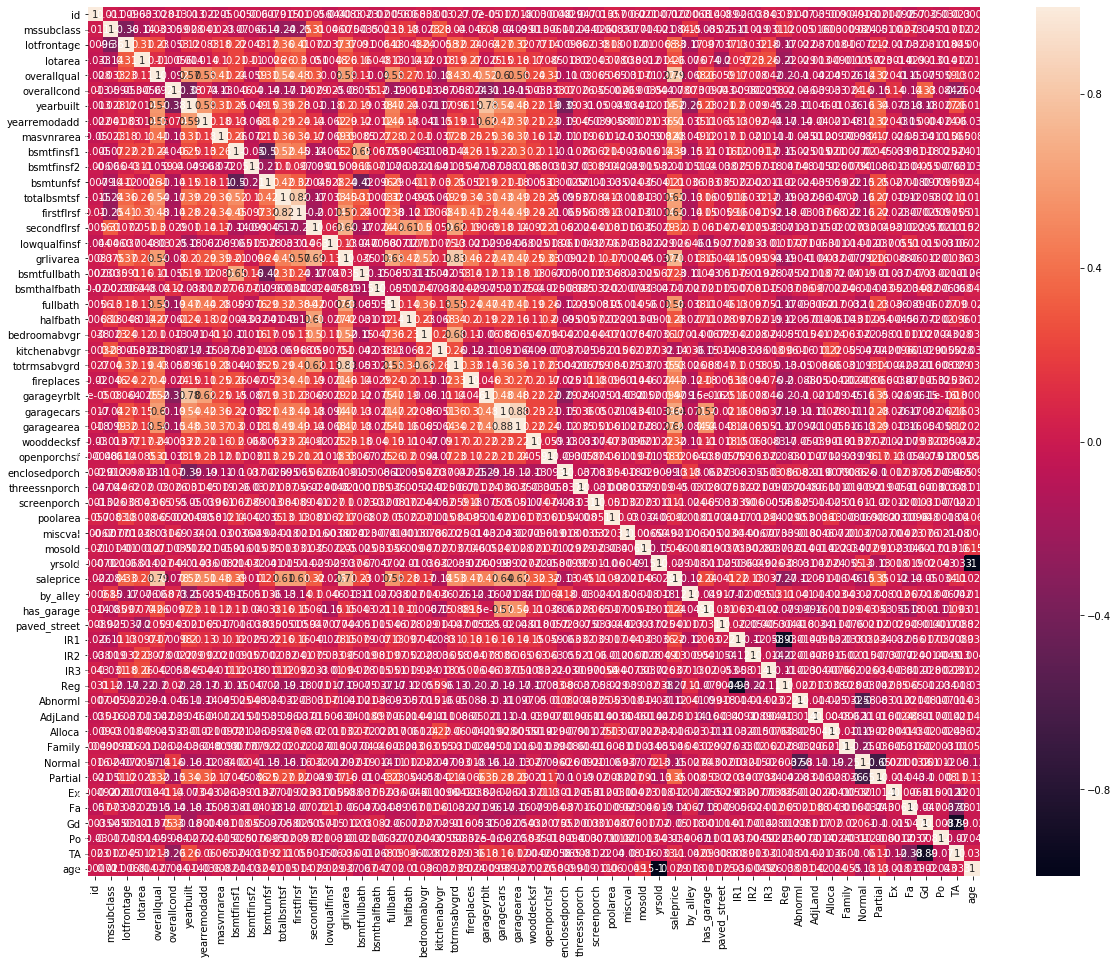

overallqual     0.790982
yearbuilt       0.522897
yearremodadd    0.507101
totalbsmtsf     0.613581
firstflrsf      0.605852
grlivarea       0.708624
fullbath        0.560664
totrmsabvgrd    0.533723
garagecars      0.640409
garagearea      0.623431
saleprice       1.000000
Name: saleprice, dtype: float64


In [34]:
# Create correlation matrix and identify features with high correlation to target
import seaborn as sns

plt.figure(figsize=(20,16))
cormat = house_df.corr()
sns.heatmap(cormat, annot=True)
plt.show()

cor_target = abs(cormat['saleprice'])
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

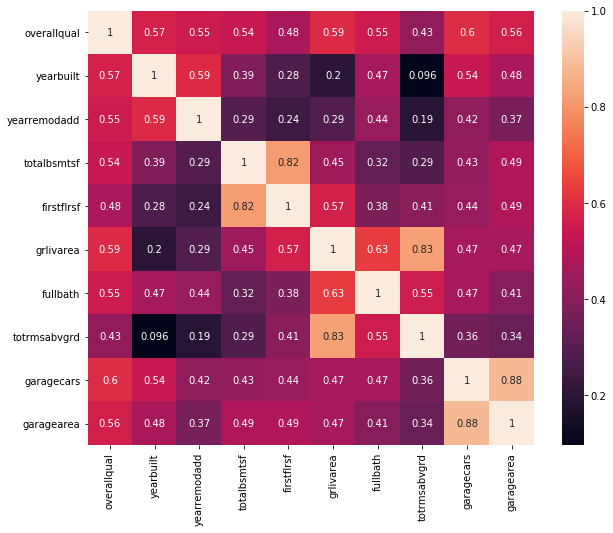

,overallqual,yearbuilt,yearremodadd,totalbsmtsf,grlivarea
overallqual,1.000000,0.572323,0.550684,0.537808,0.593007
yearbuilt,0.572323,1.000000,0.592855,0.391452,0.199010
yearremodadd,0.550684,0.592855,1.000000,0.291066,0.287389
totalbsmtsf,0.537808,0.391452,0.291066,1.000000,0.454868
grlivarea,0.593007,0.199010,0.287389,0.454868,1.000000


In [43]:
# Create new DF with only high correlation variables
house_df_rf = house_df[['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', 
                        'firstflrsf', 'grlivarea', 'fullbath', 'totrmsabvgrd', 
                        'garagecars', 'garagearea']]

# Check correlation between variables
plt.figure(figsize=(10,8))
sns.heatmap(house_df_rf.corr(), annot=True)
plt.show()

# Drop variables that are highly correlated with each other
house_df_rf = house_df_rf.drop(['garagecars', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'garagearea'], axis=1)
house_df_rf.corr()

In [46]:
# Standardize remaining features and create model
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import linear_model

# PCA, component determination
Y = house_df['saleprice']
X = sm.add_constant(scale(house_df_rf))

lrm = linear_model.LinearRegression()
lrm.fit(X,Y)
results = sm.OLS(Y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     925.9
Date:                Tue, 17 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:39:00   Log-Likelihood:                -17499.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1454   BIC:                         3.504e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.809e+05   1018.185    177.690      0.0

In [49]:
# Split to train and test sets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

X_train = sm.add_constant(X_train)
y_preds = lrm.predict(sm.add_constant(X_test))

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

# Check with cross validation
cv = cross_val_score(lrm, X_train, y_train, cv=10)
print('cross validation, max value: ', cv.max())
print('cross validation, min value: ', cv.min())
print('range of values: ', cv.max() - cv.min())

R-squared of the model in the training set is: 0.7545174538972395
-----Test set statistics-----
R-squared of the model in the test set is: 0.7846172148476732
Mean absolute error of the prediction is: 25405.57573113512
Mean squared error of the prediction is: 1446016283.2393703
Root mean squared error of the prediction is: 38026.52078798914
Mean absolute percentage error of the prediction is: 15.43145722075863
cross validation, max value:  0.8515336503686595
cross validation, min value:  0.4320736520012516
range of values:  0.4194599983674079


In [ ]:
# Create interaction variables
house_df['age_condition'] = house_df['age'] * house_df['overallcond']

# Reset feature set
X = sm.add_constant(pca.fit_transform(scale(house_df)))
lrm.fit(X,Y)

# Split to training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

y_preds_train = lrm.predict(sm.add_constant(X_test))
y_preds_test = lrm.predict(sm.add_constant(X_test))

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# Check with cross validation
cv = cross_val_score(lrm, X_train, y_train, cv=10)
print('cross validation, max value: ', cv.max())
print('cross validation, min value: ', cv.min())
print('range of values: ', cv.max() - cv.min())

In [ ]:
# Ridge Regression
rreg = linear_model.Lasso(alpha=10**3)
rreg.fit(X_train, y_train)

y_preds_train = rreg.predict(sm.add_constant(X_train))
y_preds_test = rreg.predict(sm.add_constant(X_test))

print("R-squared of the model in the training set is: {}".format(rreg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(rreg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# Check with cross validation
cv = cross_val_score(rreg, X_train, y_train, cv=10)
print('cross validation, max value: ', cv.max())
print('cross validation, min value: ', cv.min())
print('range of values: ', cv.max() - cv.min())

In [ ]:
# Lasso Regression
lreg = linear_model.Ridge(alpha=10**3)
lreg.fit(X_train, y_train)

y_preds_train = lreg.predict(sm.add_constant(X_train))
y_preds_test = lreg.predict(sm.add_constant(X_test))

print("R-squared of the model in the training set is: {}".format(lreg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lreg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# Check with cross validation
cv = cross_val_score(lreg, X_train, y_train, cv=10)
print('cross validation, max value: ', cv.max())
print('cross validation, min value: ', cv.min())
print('range of values: ', cv.max() - cv.min())

In [ ]:
# ElasticNet Regression
enreg = linear_model.ElasticNet(alpha=1, l1_ratio=.4)
enreg.fit(X_train, y_train)

y_preds_train = enreg.predict(sm.add_constant(X_train))
y_preds_test = enreg.predict(sm.add_constant(X_test))

print("R-squared of the model in the training set is: {}".format(enreg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(enreg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# Check with cross validation
cv = cross_val_score(lreg, X_train, y_train, cv=10)
print('cross validation, max value: ', cv.max())
print('cross validation, min value: ', cv.min())
print('range of values: ', cv.max() - cv.min())

Based on the various regression models, ElasticNet seems to return the optimal indicator values. With elasticnet loss function set as alpha=1 and l1_ratio=.4 in the model, we get the best indicator values for MAE, MSE, RMSE, and MAPE of the three test set regression models. Indicator values in a simple linear regression model are actually better than any of the three test set regression models, although cross validation reveals that they have extreme variance in the values of each of 10 folds, suggesting that they overfit the data. 